In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mne
import pywt
from torch.utils.data import DataLoader, Dataset , Subset
from torch import nn
import torch
import pickle
import os
from datetime import datetime
import sqlite3
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import TensorBoardLogger

from torchmetrics.functional.classification.accuracy import accuracy


In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Training on device: {device}')

Training on device: cuda


In [45]:
class CWTDataset(Dataset):
    def __init__(self, db_path, sequence_length=4000):
        self.db_path = db_path
        self.sequence_length = sequence_length
        self.conn = sqlite3.connect(db_path)
        self.cursor = self.conn.cursor()
        self.cursor.execute("SELECT COUNT(*) FROM wavelet_transforms")
        self.total_samples = self.cursor.fetchone()[0]

    def __len__(self):
        # Aby umożliwić nachodzenie, liczba możliwych sekwencji będzie równa liczbie próbek minus długość sekwencji + 1
        return self.total_samples - self.sequence_length + 1

    def __getitem__(self, idx):
        # Zwraca sekwencję próbek i target z ostatniej próbki
       
        query = (
            "SELECT cwt_data, target FROM wavelet_transforms WHERE id BETWEEN ? AND ?"
        )
        # print(f"inx {idx + 1}  index+l{idx + self.sequence_length}")
        self.cursor.execute(
            query, (idx + 1, idx + self.sequence_length)
        )  # SQLite indeksuje od 1
        rows = self.cursor.fetchall()

        cwt_sequence = torch.stack([pickle.loads(row[0]) for row in rows])
        # cwt_sequence = cwt_sequence.view(self.sequence_length,-1)

        # Target ostatniej próbki w sekwencji
        target = rows[-1][1]
        # print(f"cwt_seq {cwt_sequence.shape} target {target}")
        # cwt_tensor = torch.tensor(cwt_sequence, dtype=torch.float32)
        # cwt_tensor = cwt_tensor.view(self.sequence_length,-1)
        # target_tensor = torch.tensor(target, dtype=torch.int64)
        return cwt_sequence, target

    def __del__(self):
        self.conn.close()

In [46]:
class CWTSubset(Dataset): 
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __getitem__(self, idx):
        row = self.dataset.__getitem__(int(self.indices[idx]))
        return row
    def __len__(self):
        return len(self.indices)

In [47]:
from torch.utils.data import DataLoader

# Tworzenie instancji datasetu
cwt_dataset = CWTDataset('cwt_data.db', 4000)

# batch_size = 10  # Liczba sekwencji w jednym batchu
# train_loader = DataLoader(dataset=cwt_dataset, batch_size=batch_size, shuffle=True,num_workers=15)


In [48]:
cwt_dataset.__getitem__(0)

(tensor([[0.0662, 0.0964, 0.1746,  ..., 0.4600, 0.9574, 0.9780],
         [0.0329, 0.0921, 0.1953,  ..., 0.4547, 0.9566, 0.9736],
         [0.0074, 0.0463, 0.1845,  ..., 0.4555, 0.9672, 0.9762],
         ...,
         [0.0038, 0.0551, 0.1627,  ..., 0.9985, 1.1449, 1.6198],
         [0.0128, 0.0820, 0.1809,  ..., 0.9897, 1.1652, 1.6168],
         [0.0635, 0.1432, 0.1910,  ..., 0.9986, 1.1706, 1.6016]]),
 0)

In [49]:
cwt_dataset.__getitem__(1)[0].shape

torch.Size([4000, 640])

In [50]:
cwt_dataset.__getitem__(2000)[1]

2

In [51]:
# class LSTMModel(nn.Module):
#     def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
#         super(LSTMModel, self).__init__()
#         self.hidden_dim = hidden_dim
#         self.layer_dim = layer_dim
#         self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, output_dim)
    
#     def forward(self, x):
#         # Inicjalizacja stanów ukrytych
#         h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device=x.device)
#         c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device=x.device)
        
#         # Forward pass through LSTM layer
#         out, (hn, cn) = self.lstm(x, (h0, c0))
        
#         # Forward pass through linear layer
#         out = self.fc(out[:, -1, :])
#         return out

In [52]:
# # Parametry
# input_dim = 640
# hidden_dim = 100
# layer_dim = 1
# output_dim = 1
# num_epochs = 20
# learning_rate = 0.01

# model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim).to(device)
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# # Pętla treningowa
# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0
#     for batch_idx, (data, targets) in enumerate(train_loader):
#         # Przeniesienie danych na GPU
#         data = data.view(-1, 4000, 640).to(device)
#         targets = targets.to(device)
        
#         optimizer.zero_grad()
#         outputs = model(data)
        
#         loss = criterion(outputs, targets.float().unsqueeze(1))
#         loss.backward()
#         optimizer.step()
        
#         total_loss += loss.item()
#         print(f'Epoch: {epoch+1}, Batch: {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}')
#     avg_train_loss = train_loss / len(train_loader)
#     # Walidacja
#     val_loss = evaluate_model(model, validation_loader, device)  # załóżmy, że mamy validation_loader

#     # Wyświetlanie postępów
#     print(f'Epoch: {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}')

#     # Zapisywanie modelu, gdy jest najlepszy na walidacji
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         torch.save(model.state_dict(), 'best_model.pth')
#         print(f'Best model saved with validation loss: {val_loss:.4f}')


In [53]:
# DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=15)

In [54]:
class CWT_EEG(LightningModule):
    def __init__(
        self, batch_size,sequence_length, input_size, hidden_size, num_layers, lr, label_smoothing=0
    ):
        super().__init__()
        self.hparams.batch_size = batch_size
        self.hparams.input_size = input_size
        self.hparams.sequence_length = sequence_length
        self.hparams.lr = lr
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_of_classes = 3
        self.val_percent = 0.01
        self.loss = torch.nn.CrossEntropyLoss(label_smoothing=label_smoothing)
        self.save_hyperparameters()

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, self.num_of_classes)  # Klasyfikacja na 3 klasy

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # print(x.shape)
        #x = x.reshape(self.hparams.batch_size, self.hparams.sequence_length, -1)  # Wynikowy kształt: (r10, 4000, 640)
        
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = hn[-1, :, :]  # Ostatnia warstwa LSTM (batch_size, hidden_size)
        out = self.fc(out)

        return out

    # custom
    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    # only for HP
    def on_train_start(self):
        self.logger.log_hyperparams(
            self.hparams,
            {
                "hp/train_loss": float("nan"),
                "hp/train_acc": float("nan"),
                "hp/val_loss": float("nan"),
                "hp/val_acc": float("nan"),
            },
        )

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y, task="multiclass", num_classes=self.num_of_classes)

        self.log("hp/train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("hp/train_acc", acc, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y, task="multiclass", num_classes=self.num_of_classes)

        self.log("hp/val_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("hp/val_acc", acc, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def create_train_val_split(self, data_length, val_percent, sequence_length):
        available_lenght = data_length - sequence_length
        val_count = int(val_percent * available_lenght)
        all_indices = np.arange(available_lenght)
        val_indices = np.sort(np.random.choice(all_indices, size=val_count, replace=False))
        mask = np.ones(available_lenght, dtype=bool)
        for idx in val_indices:
            start = max(0, idx - sequence_length + 1)
            end = min(available_lenght, idx + sequence_length)
            mask[start:end] = False
        train_indices = list(np.where(mask)[0])
        val_indices = list(val_indices)
        return train_indices, val_indices

    def setup(self, stage=None):
        self.ds = CWTDataset("cwt_data.db", self.hparams.sequence_length)
        train_indices, val_indices = self.create_train_val_split(len(self.ds), self.val_percent, self.hparams.sequence_length)

        # Tworzenie podzbiorów danych z wykorzystaniem wygenerowanych indeksów
        self.train_set = CWTSubset(self.ds, train_indices)
        self.val_set = CWTSubset(self.ds, val_indices)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_set, batch_size=self.hparams.batch_size, num_workers=14,shuffle=True
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_set, batch_size=self.hparams.batch_size, num_workers=14
        )
    def get_len_train_val(self):
            self.setup()
            return len(self.train_set), len(self.val_set)

In [55]:
lr = 0.001

model = CWT_EEG( batch_size= 11 ,sequence_length = 30,input_size=640 , num_layers=3,hidden_size=3, lr=lr).to(device)
logger = TensorBoardLogger("lightning_logs", name="CWT_EEG")
logger.log_hyperparams(model.hparams, {})
trainer = Trainer(
    max_epochs=10,
    logger=logger

)
print(model.get_len_train_val())
trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type             | Params
------------------------------------------
0 | loss | CrossEntropyLoss | 0     
1 | lstm | LSTM             | 7.9 K 
2 | fc   | Linear           | 12    
------------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.032     Total estimated model params size (MB)


(21816, 389)
Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 1:   9%|▊         | 169/1972 [00:04<00:45, 39.38it/s, v_num=114, hp/train_loss_step=0.669, hp/train_acc_step=0.818, hp/val_loss_step=0.484, hp/val_acc_step=1.000, hp/val_loss_epoch=1.020, hp/val_acc_epoch=0.550, hp/train_loss_epoch=0.986, hp/train_acc_epoch=0.533] 

/home/daniel/miniconda3/envs/EEG311/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
def create_train_val_split( data_length, val_percent, sequence_length):
    available_lenght = data_length - sequence_length
    val_count = int(val_percent * available_lenght)
    all_indices = np.arange(available_lenght)
    val_indices = np.sort(np.random.choice(all_indices, size=val_count, replace=False))
    mask = np.ones(available_lenght, dtype=bool)
    for idx in val_indices:
        start = max(0, idx - sequence_length + 1)
        end = min(available_lenght, idx + sequence_length)
        mask[start:end] = False
    train_indices = np.where(mask)[0]
    #convert evry number to int
    train_indices = list(train_indices)
    val_indices = list(val_indices)

    return train_indices, val_indices

In [ ]:
ds = CWTDataset("cwt_data.db", 20)

In [ ]:
ds_row = ds.__getitem__(0)

In [ ]:
i_t, i_v = create_train_val_split(1000, 0.05, 20)

In [ ]:
import torch

# Przykładowy tensor o wymiarach [10, 30, 64, 10]
x = torch.randn(10, 30, 64, 10)

# Zmiana kształtu tensora do [10, 30, 640]
x_reshaped = x.reshape(10, 30, -1)

print(x_reshaped.shape)
# Output: torch.Size([10, 30, 640])

torch.Size([10, 30, 640])


In [ ]:
class CWTSubset(Dataset): 
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __getitem__(self, idx):
        row = self.dataset.__getitem__(int(self.indices[idx]))
        return row
    def __len__(self):
        return len(self.indices)

In [ ]:
ds_t = CWTSubset(ds, i_t)

In [ ]:
x= ds[165]

In [ ]:
x

(tensor([[0.0049, 0.0441, 0.0915,  ..., 0.2858, 0.7384, 0.3552],
         [0.0032, 0.0475, 0.0988,  ..., 0.2943, 0.7405, 0.3650],
         [0.0188, 0.0370, 0.1108,  ..., 0.3013, 0.7353, 0.3513],
         ...,
         [0.0115, 0.0175, 0.0808,  ..., 0.4260, 0.6755, 0.2518],
         [0.0193, 0.0257, 0.0696,  ..., 0.4363, 0.6622, 0.2383],
         [0.0424, 0.0539, 0.0636,  ..., 0.4490, 0.6530, 0.2420]]),
 tensor(0))

In [ ]:
ds_t.__getitem__(0)

(tensor([[0.0662, 0.0964, 0.1746,  ..., 0.4600, 0.9574, 0.9780],
         [0.0329, 0.0921, 0.1953,  ..., 0.4547, 0.9566, 0.9736],
         [0.0074, 0.0463, 0.1845,  ..., 0.4555, 0.9672, 0.9762],
         ...,
         [0.0114, 0.0563, 0.0641,  ..., 0.4323, 0.9982, 0.9488],
         [0.0245, 0.0552, 0.0680,  ..., 0.4266, 0.9775, 0.9510],
         [0.0077, 0.0627, 0.0744,  ..., 0.4228, 0.9568, 0.9530]]),
 tensor(0))

In [ ]:
ds_t = Subset(ds, i_t)

In [ ]:
ds_t_row = ds_t.__getitem__(0)

IndexError: list index out of range

In [ ]:
ds_t_row

(tensor([], size=(30, 0)), tensor(1))

In [ ]:
for i in range(len(ds_t)):   
    try:
        ds_t.__getitem__(i)

    except:
        print(i)
        continue

/tmp/ipykernel_4767/4025908726.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_tensor = torch.tensor(target, dtype=torch.int64)


In [ ]:
ds_v = Subset(ds, i_v)
for i in range(len(ds_v)):   
    try:
        ds_v.__getitem__(i)

    except:
        print(i)
        continue

/tmp/ipykernel_4767/4025908726.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_tensor = torch.tensor(target, dtype=torch.int64)


In [ ]:
len(ds)

38971

In [ ]:
train_indices, val_indices = create_train_val_split(len(ds), 0.2, 2)

In [ ]:
val_indices

[7,
 9,
 15,
 19,
 23,
 36,
 39,
 43,
 45,
 61,
 67,
 68,
 74,
 77,
 79,
 81,
 86,
 90,
 98,
 106,
 114,
 120,
 121,
 123,
 125,
 126,
 128,
 129,
 131,
 153,
 158,
 170,
 174,
 182,
 187,
 191,
 196,
 198,
 202,
 216,
 231,
 232,
 236,
 239,
 241,
 249,
 255,
 258,
 262,
 263,
 271,
 276,
 284,
 287,
 295,
 300,
 307,
 319,
 329,
 332,
 333,
 335,
 339,
 343,
 349,
 352,
 355,
 361,
 365,
 370,
 381,
 390,
 393,
 395,
 403,
 412,
 417,
 423,
 430,
 440,
 446,
 452,
 458,
 467,
 468,
 478,
 484,
 487,
 491,
 492,
 494,
 498,
 499,
 503,
 526,
 528,
 530,
 539,
 544,
 558,
 560,
 575,
 579,
 580,
 581,
 584,
 590,
 591,
 601,
 608,
 612,
 618,
 620,
 631,
 632,
 634,
 645,
 659,
 662,
 666,
 668,
 672,
 681,
 683,
 684,
 695,
 697,
 703,
 704,
 705,
 706,
 708,
 711,
 723,
 725,
 737,
 746,
 747,
 749,
 750,
 753,
 759,
 762,
 765,
 769,
 771,
 772,
 773,
 776,
 781,
 785,
 802,
 803,
 827,
 829,
 833,
 835,
 841,
 845,
 852,
 855,
 857,
 858,
 860,
 867,
 869,
 870,
 871,
 875,
 882,
 

In [ ]:
train_indices

[0,
 1,
 2,
 3,
 4,
 5,
 11,
 12,
 13,
 17,
 21,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 41,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 63,
 64,
 65,
 70,
 71,
 72,
 83,
 84,
 88,
 92,
 93,
 94,
 95,
 96,
 100,
 101,
 102,
 103,
 104,
 108,
 109,
 110,
 111,
 112,
 116,
 117,
 118,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 155,
 156,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 172,
 176,
 177,
 178,
 179,
 180,
 184,
 185,
 189,
 193,
 194,
 200,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 229,
 234,
 243,
 244,
 245,
 246,
 247,
 251,
 252,
 253,
 260,
 265,
 266,
 267,
 268,
 269,
 273,
 274,
 278,
 279,
 280,
 281,
 282,
 289,
 290,
 291,
 292,
 293,
 297,
 298,
 302,
 303,
 304,
 305,
 309,
 310,
 311,
 312,
 313,
 314,
 315,
 316,
 317,
 321,
 322,
 323,
 324,
 325,
 326,
 327,

In [ ]:
len(train_indices)

20060

In [ ]:
train_ds = Subset(ds, train_indices)
val_ds = Subset(ds, val_indices)

In [ ]:
len(val_ds)

7793

In [ ]:
val_ds.__getitem__(0)[0]

/tmp/ipykernel_4767/4025908726.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_tensor = torch.tensor(target, dtype=torch.int64)


tensor([], size=(30, 0))

In [ ]:
train_ds.__getitem__(0)

/tmp/ipykernel_4767/4025908726.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_tensor = torch.tensor(target, dtype=torch.int64)


(tensor([], size=(30, 0)), tensor(1))

In [ ]:
x = model.loss

In [ ]:
ds = CWTDataset('cwt_data.db', 30)
len(ds)


38971

In [ ]:
# print first 4k stampels
for i in range(4000):
    data = ds.__getitem__(i)[0].cpu().numpy()
    target = ds.__getitem__(i)[1].cpu().numpy()
    print(f"{i}.    data: {data.shape}  target: {target}")

/tmp/ipykernel_4767/4025908726.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_tensor = torch.tensor(target, dtype=torch.int64)


0.    data: (30, 640)  target: 1
1.    data: (30, 640)  target: 1
2.    data: (30, 640)  target: 1
3.    data: (30, 640)  target: 1
4.    data: (30, 640)  target: 1
5.    data: (30, 640)  target: 1
6.    data: (30, 640)  target: 1
7.    data: (30, 640)  target: 1
8.    data: (30, 640)  target: 1
9.    data: (30, 640)  target: 1
10.    data: (30, 640)  target: 1
11.    data: (30, 640)  target: 1
12.    data: (30, 640)  target: 1
13.    data: (30, 640)  target: 1
14.    data: (30, 640)  target: 1
15.    data: (30, 640)  target: 1
16.    data: (30, 640)  target: 1
17.    data: (30, 640)  target: 1
18.    data: (30, 640)  target: 1
19.    data: (30, 640)  target: 1
20.    data: (30, 640)  target: 1
21.    data: (30, 640)  target: 1
22.    data: (30, 640)  target: 1
23.    data: (30, 640)  target: 1
24.    data: (30, 640)  target: 1
25.    data: (30, 640)  target: 1
26.    data: (30, 640)  target: 1
27.    data: (30, 640)  target: 1
28.    data: (30, 640)  target: 1
29.    data: (30, 640)  

382.    data: (30, 640)  target: 1
383.    data: (30, 640)  target: 1
384.    data: (30, 640)  target: 1
385.    data: (30, 640)  target: 1
386.    data: (30, 640)  target: 1
387.    data: (30, 640)  target: 1
388.    data: (30, 640)  target: 1
389.    data: (30, 640)  target: 1
390.    data: (30, 640)  target: 1
391.    data: (30, 640)  target: 1
392.    data: (30, 640)  target: 1
393.    data: (30, 640)  target: 1
394.    data: (30, 640)  target: 1
395.    data: (30, 640)  target: 1
396.    data: (30, 640)  target: 1
397.    data: (30, 640)  target: 1
398.    data: (30, 640)  target: 1
399.    data: (30, 640)  target: 1
400.    data: (30, 640)  target: 1
401.    data: (30, 640)  target: 1
402.    data: (30, 640)  target: 1
403.    data: (30, 640)  target: 1
404.    data: (30, 640)  target: 1
405.    data: (30, 640)  target: 1
406.    data: (30, 640)  target: 1
407.    data: (30, 640)  target: 1
408.    data: (30, 640)  target: 1
409.    data: (30, 640)  target: 1
410.    data: (30, 6

In [ ]:
dl = torch.utils.data.DataLoader(ds, batch_size=1, num_workers=14,shuffle=True)



In [ ]:
for i, (x, y) in enumerate(dl):
    print(f"{i}.    data: {x.shape}  target: {y}")
    if i == 10:
        break

/tmp/ipykernel_4767/4025908726.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_tensor = torch.tensor(target, dtype=torch.int64)
/tmp/ipykernel_4767/4025908726.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_tensor = torch.tensor(target, dtype=torch.int64)
/tmp/ipykernel_4767/4025908726.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_tensor = torch.tensor(target, dtype=torch.int64)
/tmp/ipykernel_4767/4025908726.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.cl

0.    data: torch.Size([1, 30, 640])  target: tensor([1])
1.    data: torch.Size([1, 30, 640])  target: tensor([1])
2.    data: torch.Size([1, 30, 640])  target: tensor([1])
3.    data: torch.Size([1, 30, 640])  target: tensor([1])
4.    data: torch.Size([1, 30, 640])  target: tensor([1])
5.    data: torch.Size([1, 30, 640])  target: tensor([1])
6.    data: torch.Size([1, 30, 640])  target: tensor([1])
7.    data: torch.Size([1, 30, 640])  target: tensor([1])
8.    data: torch.Size([1, 30, 640])  target: tensor([1])
9.    data: torch.Size([1, 30, 640])  target: tensor([1])
10.    data: torch.Size([1, 30, 640])  target: tensor([1])


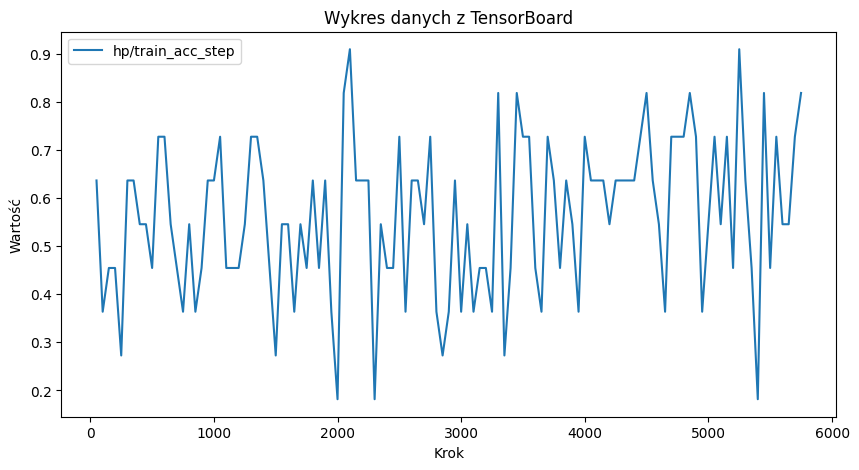

In [ ]:
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

def load_tensorboard_scalars(logdir):
    # Tworzy akumulator do odczytu danych
    ea = event_accumulator.EventAccumulator(logdir,
        size_guidance={event_accumulator.SCALARS: 0})  # 0 = bez ograniczeń
    ea.Reload()  # Wczytaj wszystkie dane z dysku

    # Odczyt danych skalarnych
    scalars = {}
    for tag in ea.Tags()['scalars']:
        events = ea.Scalars(tag)
        scalars[tag] = [(e.wall_time, e.step, e.value) for e in events]

    return scalars

# Ścieżka do katalogu z logami TensorBoard
logdir = '/home/daniel/repos/Decoding_of_EEG/lightning_logs/CWT_EEG/version_51/events.out.tfevents.1713204451.pop-os.32833.5'

# Wczytanie danych
scalars = load_tensorboard_scalars(logdir)

# Przykład wyświetlenia danych skalarnych
tag = 'hp/train_acc_step'  # Zmień na odpowiedni tag, który chcesz wyświetlić
times, steps, values = zip(*scalars[tag])

plt.figure(figsize=(10, 5))
plt.plot(steps, values, label=tag)
plt.xlabel('Krok')
plt.ylabel('Wartość')
plt.title('Wykres danych z TensorBoard')
plt.legend()
plt.show()
